<a href="https://colab.research.google.com/github/kushpal/Master-Thesis/blob/master/Ensemble_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Extended Version of Decision tree**

In [0]:
### Import all the needful libraries 

from csv import reader
from random import seed
from random import randrange 

### Load the csv file

def loading_csv_file(path):
    f=open(path,'rt')
    dataset=reader(f)
    dataset=list(dataset)
    return dataset

### Matric to find out the model's accuracy

def accuracy_metric(actual, predicted): 
    True_P = 0 
    for j in range(len(actual)):
        if actual[j] == predicted[j]:
            True_P += 1
    return True_P / float(len(actual)) * 100.0

### Create a terminal node for value
def Terminal_node(grp):
	outcomes = [row[-1] for row in grp]
	return max(set(outcomes), key=outcomes.count)

### Algorithm to evaluate the decision tree

def algorithm(dataset, decisiontree, n_folds, *args):
    #split the data in k folds
    data = dataset
    n_f = n_folds
    s_dataset = list()  
    c_dataset = list(data) 
    fold_size = int(len(data) / n_f)  #size of each fold 
    for i in range(0,n_f):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(c_dataset))
            fold.append(c_dataset.pop(index))
        s_dataset.append(fold)
        folds = s_dataset
    
    scores = list()   
    for fold in folds:
        trainset_data = list(folds)
        trainset_data.remove(fold)  
        trainset_data = sum(trainset_data, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = decisiontree(trainset_data, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

### Split the dataset based on an attribute either in the right or left. 

def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

### Choose the root based on the Gini index

def gini_index(grps, classes):
	no_instances = float(sum([len(grp) for grp in grps]))
	gini_val = 0.0
	for grp in grps:
		size = float(len(grp))
		if size == 0:
			continue
		score = 0.0
		for class_val in classes:
			p = [row[-1] for row in grp].count(class_val) / size
			score += p * p
		gini_val += (1.0 - score) * (size / no_instances)
	return gini_val

### Build a decision tree which uses depth and leaf minimum size.

def build_tree(train, max_depth, Leaf_min_size):
	root_node = get_split(train)
	Child_split(root_node, max_depth, Leaf_min_size, 1)
	return root_node

### Predict something using decision tree

def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']


### select the best split point for the dataset using gini index.

def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_grps = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			grps = test_split(index, row[index], dataset)
			gini = gini_index(grps, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_grps = index, row[index], gini, grps
	return {'index':b_index, 'value':b_value, 'grps':b_grps}

### Create child splits for a node 

def Child_split(node, max_depth, Leaf_min_size, depth):
	left, right = node['grps']
	del(node['grps'])
	if not left or not right:
		node['left'] = node['right'] = Terminal_node(left + right)
		return
	if len(left) <= Leaf_min_size:
		node['left'] = Terminal_node(left)
	else:
		node['left'] = get_split(left)
		Child_split(node['left'], max_depth, Leaf_min_size, depth+1)
	if depth >= max_depth:
		node['left'], node['right'] = Terminal_node(left), Terminal_node(right)
		return
	if len(right) <= Leaf_min_size:
		node['right'] = Terminal_node(right)
	else:
		node['right'] = get_split(right)
		Child_split(node['right'], max_depth, Leaf_min_size, depth+1)


### CART Algorithm

def making_decisiontree(train_data, test_data, max_depth, Leaf_min_size):
	tree = build_tree(train_data, max_depth, Leaf_min_size)
	predictions = list()
	for row in test_data:
		prediction = predict(tree, row)
		predictions.append(prediction)
	return(predictions)
 
### Create a random subsample from the dataset with replacement

def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample
 
### Make a prediction with a list of bagged trees

def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)
 

### Random Forest Algorithm

def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)
 
###  MAIN FUNCTIONALITY 

filename = 'iris.csv'
dataset = loading_csv_file(filename)

number_of_folds =3
max_depth_tree = 5
leaf_min_size = 3
print( "                      ALGORITHM FOR WHOLE DATASET           ")
print (" ")
print ("THE SIZE OF DATASET :",len(dataset))
print( "NUMBER OF FOLDS :",number_of_folds)
print ("MAXIMUM DEPTH OF THE TREE :",max_depth_tree)
print ("MINIMUM SIZE OF LEAF NODE :",leaf_min_size)
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1, 5, 10]:
	scores = algorithm(dataset,random_forest,number_of_folds, max_depth_tree, leaf_min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	print('Scores in Array: %s' % scores)
	print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))



                      ALGORITHM FOR WHOLE DATASET           
 
THE SIZE OF DATASET : 151
NUMBER OF FOLDS : 3
MAXIMUM DEPTH OF THE TREE : 5
MINIMUM SIZE OF LEAF NODE : 3
Trees: 1
Scores in Array: [98.0, 80.0, 96.0]
Mean Accuracy: 91.333%
Trees: 5
Scores in Array: [96.0, 100.0, 98.0]
Mean Accuracy: 98.000%
Trees: 10
Scores in Array: [98.0, 94.0, 92.0]
Mean Accuracy: 94.667%


## Q1.B Parallelised version of random forest

In [0]:
from multiprocessing import Process,Pipe
from math import sqrt

def algorithm(dataset, method, n_folds, *args):
   #split the data in k folds
        data = dataset
        n_f = n_folds
        s_dataset = list()  
        c_dataset = list(data) 
        Train_data = int(len(data)*70 /100)  # Data for training the dataset
        Test_data =  int(len(data)*30 /100)  # Data for testing the dataset
        fold = list()
        while len(fold) < Train_data:
            index = randrange(len(c_dataset))
            fold.append(c_dataset.pop(index))
        s_dataset.append(fold)
        
        fold = list()
        while len(fold)<Test_data :
            index = randrange(len(c_dataset))
            fold.append(c_dataset.pop(index))
        s_dataset.append(fold)
        folds = s_dataset
        scores=list()
        train_set = s_dataset[0] 
        test_set= s_dataset[1]
        print( 'The size of training data :',len(train_set))
        print ('The size of Test data :',len(test_set))
        predicted = method(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
        return scores


###  MAIN FUNCTIONALITY 

filename = 'iris.csv'
dataset = loading_csv_file(filename)

number_of_folds =3
max_depth_tree = 5
leaf_min_size = 3
print ("          ALGORITHM(PARALLEL RANDOM FOREST) FOR TRAINING AND TESTING (70% TRANING DATA AND 30% TESTING DATA )           ")
print (" ")
print ("THE SIZE OF DATASET :",len(dataset))
print( "NUMBER OF FOLDS :",number_of_folds)
print ("MAXIMUM DEPTH OF THE TREE :",max_depth_tree)
print ("MINIMUM SIZE OF LEAF NODE :",leaf_min_size)
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1,10,20]:
	scores = algorithm(dataset,random__forest,number_of_folds, max_depth_tree, leaf_min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	print('Scores in Array: %s' % scores)
	print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))


          ALGORITHM(PARALLEL RANDOM FOREST) FOR TRAINING AND TESTING (70% TRANING DATA AND 30% TESTING DATA )           
 
THE SIZE OF DATASET : 151
NUMBER OF FOLDS : 3
MAXIMUM DEPTH OF THE TREE : 5
MINIMUM SIZE OF LEAF NODE : 3
The size of training data : 105
The size of Test data : 45
Trees: 1
Scores in Array: [88.88888888888889]
Mean Accuracy: 88.889%
The size of training data : 105
The size of Test data : 45
Trees: 10
Scores in Array: [95.55555555555556]
Mean Accuracy: 95.556%
The size of training data : 105
The size of Test data : 45
Trees: 20
Scores in Array: [97.77777777777777]
Mean Accuracy: 97.778%


### Compare the performance of serial and parallel versions of your implementation

We are getting the same accuracy but it can be said from the above code that it will take less amount of time in comparison to serial implementation

### The first 70% of the data used for trainining and 30% for testing

In [0]:

###  MAIN FUNCTIONALITY 

filename = 'iris.csv'
dataset = loading_csv_file(filename)

number_of_folds =3
max_depth_tree = 5
leaf_min_size = 3
print ("          ALGORITHM(RANDOM FOREST) FOR TRAINING AND TESTING (70% TRANING DATA AND 30% TESTING DATA )           ")
print (" ")
print ("THE SIZE OF DATASET :",len(dataset))
print( "NUMBER OF FOLDS :",number_of_folds)
print ("MAXIMUM DEPTH OF THE TREE :",max_depth_tree)
print ("MINIMUM SIZE OF LEAF NODE :",leaf_min_size)
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1,10,20]:
	scores = algorithm(dataset,random_forest,number_of_folds, max_depth_tree, leaf_min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	print('Scores in Array: %s' % scores)
	print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

scores = algorithm(dataset, making_decisiontree, number_of_folds, max_depth_tree, leaf_min_size,n_features)
print(" ")
print ("          ALGORITHM(DECISION TREE) FOR TRAINING AND TESTING (70% TRANING DATA AND 30% TESTING DATA    ")
print(" ")
print('Scores in Array: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

          ALGORITHM(RANDOM FOREST) FOR TRAINING AND TESTING (70% TRANING DATA AND 30% TESTING DATA )           
 
THE SIZE OF DATASET : 151
NUMBER OF FOLDS : 3
MAXIMUM DEPTH OF THE TREE : 5
MINIMUM SIZE OF LEAF NODE : 3
The size of training data : 105
The size of Test data : 45
Trees: 1
Scores in Array: [100.0]
Mean Accuracy: 100.000%
The size of training data : 105
The size of Test data : 45
Trees: 10
Scores in Array: [97.77777777777777]
Mean Accuracy: 97.778%
The size of training data : 105
The size of Test data : 45
Trees: 20
Scores in Array: [97.77777777777777]
Mean Accuracy: 97.778%
The size of training data : 105
The size of Test data : 45
 
          ALGORITHM(DECISION TREE) FOR TRAINING AND TESTING (70% TRANING DATA AND 30% TESTING DATA    
 
Scores in Array: [91.11111111111111]
Mean Accuracy: 91.111%


### Now used 5-fold cross-validation on the IRIS dataset to find the optimum number of estimators in the set of [1, 2, 5, 10, 50, 100]  estimators.

In [0]:
number_of_folds=5
Max_Estimator=0
max_score=0
leaf_min_size=3
for n_trees in [1, 2, 5, 10, 50, 100]:
    score = algorithm(dataset,random_forest,number_of_folds, max_depth_tree, leaf_min_size, sample_size, n_trees, n_features)
    mean_accuracy=(sum(score)/float(len(score)))
    if max_score<mean_accuracy:
        max_score=mean_accuracy
        Max_Estimator=n_trees
        
print ("MAXIMUM ACCURACY : ",max_score)
print ("THE OPTIMUM NUMBER OF ESTIMATOR : ",Max_Estimator)

The size of training data : 105
The size of Test data : 45
The size of training data : 105
The size of Test data : 45
The size of training data : 105
The size of Test data : 45
The size of training data : 105
The size of Test data : 45
The size of training data : 105
The size of Test data : 45
The size of training data : 105
The size of Test data : 45
MAXIMUM ACCURACY :  97.77777777777777
THE OPTIMUM NUMBER OF ESTIMATOR :  5


---
### Re-encode the IRIS dataset class as ’virginica’ and ’not-virginica’. Now apply ADABoost (on depth-1 decision trees as weak learner) while considering only ’sepal length’ and ’petal width’ as the features. Train on 100% of the data and create a Matplotlib animation for the first 4 iterations of ADAboost. The title of the plot should show the iteration number and the accuracy on the train set. The plot should color the ’virginica’ and ’not-virginica’ points differently and their marker size should correspond to their weights as per the ADABoost algortihm
---

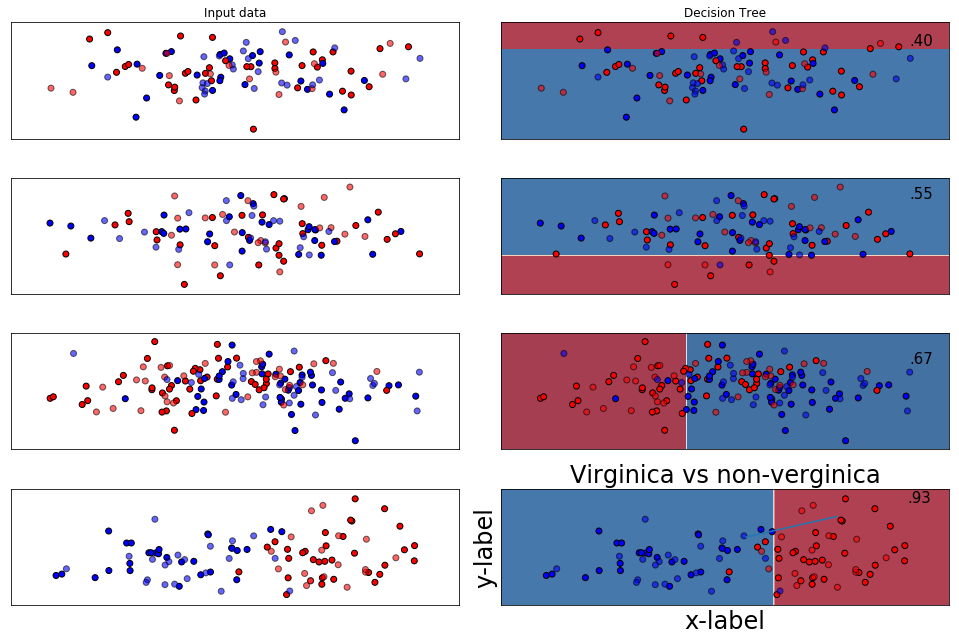

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

h = .02

def example_plot(ax, fontsize=12):
    ax.plot([1, 2])
    ax.locator_params(nbins=6)
    ax.set_xlabel('x-label', fontsize=fontsize)
    ax.set_ylabel('y-label', fontsize=fontsize)
    ax.set_title('Virginica vs non-verginica', fontsize=fontsize)

Dataset = pd.read_csv("iris.csv")

Dataset['Species'] = Dataset['Species'].replace({'virginica':'virginica','setosa': 'non-verginica', 'versicolor': 'non-verginica'})
Dataset['Species'].value_counts()

data = Dataset[['SepalLengthCm','PetalWidthCm','Species']]

Dataset['Species'] = Dataset['Species'].replace({'virginica':1,'Non-verginica':-1})



names = ["Decision Tree"]

classifiers = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=1),
    AdaBoostClassifier()
]
make_m = []
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
datasets = [make_circles(noise=0.9, factor=0.5, random_state=1),make_circles(noise=0.6, factor=0.5, random_state=2),make_moons(n_samples=150,noise=0.9, random_state=0),linearly_separable]
figure = plt.figure(figsize=(27, 9))
i = 1
d3 = tuple(d1)
d4 = tuple(d2)
d5 = [d3,d4]
for ds_cnt, ds in enumerate(datasets):
    
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")

    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')

    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')

        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)    
        ax.text(xx.max() - .2, yy.min() + 5, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 3
example_plot(ax, fontsize=24)
plt.tight_layout()
plt.show()




### After Adding some noise to the data, showing 8 iterations.

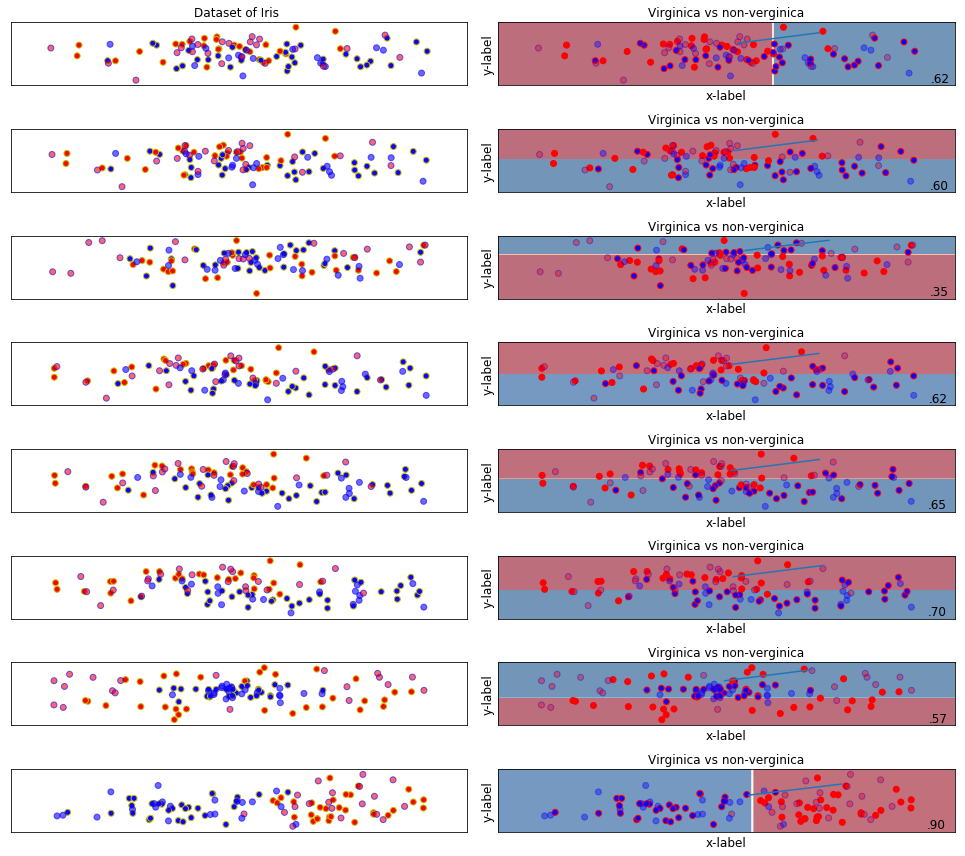

In [0]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure


h = .04  # step size in the mesh

names = ["Decision Tree"]

classifiers = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=1),
    AdaBoostClassifier()
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
datasets = [make_moons(noise=1, random_state=0),
            make_moons(noise=0.8, random_state=0),make_circles(noise=0.7, factor=0.2, random_state=1),
            make_moons(noise=0.6, random_state=0),make_moons(noise=0.5, random_state=0),make_moons(noise=0.4, random_state=0),
            make_circles(noise=0.2, factor=0.2, random_state=1),
            linearly_separable
            ]
figure = plt.figure(figsize=(27, 12))
i = 1
X1 = Dataset[['SepalLengthCm','PetalWidthCm']]
y1 = Dataset[['Species']]
d1 = X1.values
d2 = y1.values
d3 = tuple(d1)
d4 = tuple(d2)
d5 = [d3,d4]

for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X = StandardScaler().fit_transform(X)

  
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=24)
  
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0004', '#1000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Dataset of Iris ")
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='y')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='b')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.6)

        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='r')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='b', alpha=0.4)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=12, horizontalalignment='left')
        i += 3
        example_plot(ax, fontsize=12)
plt.tight_layout()
plt.show()

###  Create a dataset of 50 points where y = mx + c + random noise

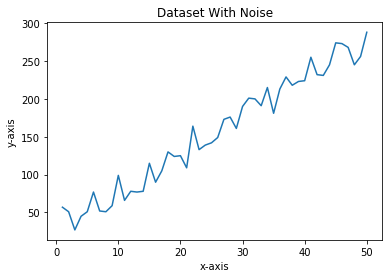

In [0]:

import numpy as np 
import matplotlib.pyplot as plt  
import random
y=[]
m=5
c=3
for i in range(1,51):
    noise=random.randint(1,51)
    y.append(m*i+c+noise)
y=np.array(y)
x = np.arange(1,51,1)    
plt.title("Dataset With Noise")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.plot(x, y) 
plt.show()   

### Plot a 5 degree fit for the data


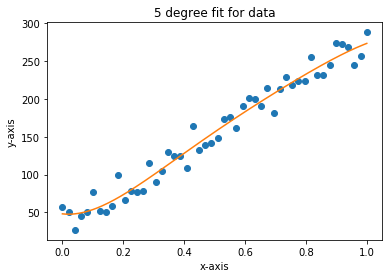

In [0]:
np.random.seed(12)
x=np.linspace(0,1,50)
p = np.poly1d(np.polyfit(x, y, 5))
#plt.show() 
t = np.linspace(0, 1, 200)
plt.plot(x, y, 'o', t, p(t), '-')
plt.title("5 degree fit for data")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

---

### Illustrating the concept of bagging on the iris dataset. For n=100 rounds of bagging, fitted 5 degree curve and commented on the average (bagged)regressor. It is less prone to variance and this setting is not able to show the efficacy of bagging, used a higher degree fit (say 20) and repeated the experiment.



---



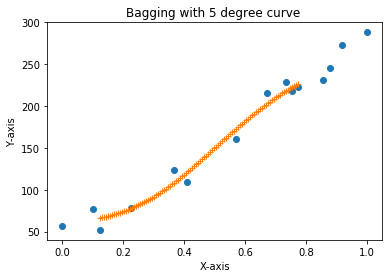

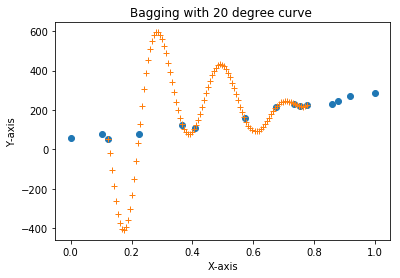

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
X=np.asarray(x).reshape(-1,1)
Y=np.asarray(y).reshape(-1,1)
x_train, x_test, y_train,y_test=train_test_split(X,Y, test_size=0.3,random_state=100)
clf = BaggingRegressor(n_estimators=100, random_state=101)

clf.fit(x_train, y_train)
clf.score(x_test,y_test)
x_test=x_test.ravel()
y_test=y_test.ravel()
p = np.poly1d(np.polyfit(x_test, y_test, 5))

t = np.linspace(x_test[0], x_test[-1], 100)
plt.plot(x_test, y_test, 'o', t, p(t), '+')
plt.title("Bagging with 5 degree curve ")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

x_test=x_test.ravel()
y_test=y_test.ravel()
p = np.poly1d(np.polyfit(x_test, y_test, 20))

t = np.linspace(x_test[0], x_test[-1], 100)
plt.plot(x_test, y_test, 'o', t, p(t), '+')
plt.title("Bagging with 20 degree curve ")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

### Generate random number without using any built in functions to understand how bagging behaves.

In [0]:
import struct
import time

def get_rand_bits(k):
    r = 0
    for _ in range(k):
        r <<= 1
        r |= struct.pack('!f', time.clock())[-1] & 1 #last bit 
    return r
def Rand_Num(a, b):
    return a + rand_below(b - a + 1)
def rand_below(n):
    k = n.bit_length() 
    r = get_rand_bits(k) 
    while r >= n:
        r = get_rand_bits(k)
    return r

### 1000 times iterated  where N = 100

In [0]:
import numpy as np 
import matplotlib.pyplot as plt  
import random
# Compute the x and y coordinates for points on a sine curve 
y=[]
z=[]
x = np.arange(1,1001,1)
for i in range(1,1001):
    y.append(Rand_Num(1,100))
    
y=np.array(y)    

plt.title("Random number graph (1,100)") 
plt.plot(x, y) 
plt.xlabel("Iterations")
plt.ylabel("Random value")
plt.show() 

**References:**

[1]. https://www.coursera.org/lecture/practical-machine-learning/bagging-6V3fC.

[2]. Machinelearningmastery.com

[3]. https://medium.com/dunnhumby-data-science-engineering/parallel-processing-of-machine-learning-algorithms-e1cff1151bef
            
[4]. https://en.wikipedia.org/wiki/Random_number_generation
           
[5]. https://www.scipy-lectures.org/intro/numpy/auto_examples/plot_polyfit.html]
            
[6]. https://plot.ly/scikit-learn/plot-mlp-alpha/